In [1]:
import sqlite3
import pandas as pd
import os
import json
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import re
import pickle

In [2]:
# Connect to database
conn = sqlite3.connect("../../../databases/MLB_Betting.db")

In [3]:
import os

print(os.getcwd())
os.chdir('../')
print(os.getcwd())

/Users/admin/Purdue + CS/MLB-AI-Betting/src/modelDevelopment/training
/Users/admin/Purdue + CS/MLB-AI-Betting/src/modelDevelopment



# CREATING PANDAS DF FOR FEATURES

In [6]:
# NEW WAY:

from utils.featureExtraction import buildFeatures

# Step 1: Load data from SQL
join_query = """
SELECT 
    Features.game_id,
    OldGames.season,
    Features.features_json
FROM 
    Features
INNER JOIN 
    OldGames ON Features.game_id = OldGames.game_id
"""
df = pd.read_sql_query(join_query, conn)

# Step 2: Parse features JSON
df["features_json"] = df["features_json"].apply(json.loads)
df["season"] = df["season"].astype(int)

# Step 3: Extract features using the utility function
X_all, y_all, feature_names = buildFeatures(df, method="diff")  


print(X_all.shape)
print(y_all.shape)
print(feature_names)
print(len(feature_names))

# Step 4: Add game_id and season back to X_all if needed
X_all = pd.concat([df[["game_id", "season"]], X_all], axis=1)
X_all["label"] = y_all

print(X_all.shape)

# Step 5: Split into train/test sets
df_train = X_all[X_all["season"] <= 2022]
df_test = X_all[X_all["season"] >= 2023]

# get the train and test sets for features and targets
X_train = df_train[feature_names]
X_test = df_test[feature_names]

Y_train = df_train["label"]
Y_test = df_test["label"]

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

game_ids_train = df_train["game_id"]
game_ids_test = df_test["game_id"]

(21972, 32)
(21972,)
['season_avg_runs_scored_diff', 'season_avg_batting_avg_diff', 'season_avg_obp_diff', 'season_avg_slg_diff', 'season_avg_ops_diff', 'season_avg_batting_k_pct_diff', 'season_avg_bb_pct_diff', 'season_avg_babip_diff', 'season_avg_runs_given_diff', 'season_avg_era_diff', 'season_avg_whip_diff', 'season_avg_opponent_obp_diff', 'season_avg_opponent_slg_diff', 'season_avg_opponent_ops_diff', 'season_avg_k_per_9_diff', 'season_avg_pitching_k_pct_diff', 'season_avg_bb_per_9_diff', 'season_avg_hr_per_9_diff', 'rolling_avg_runs_scored_diff', 'rolling_avg_batting_avg_diff', 'rolling_avg_obp_diff', 'rolling_avg_slg_diff', 'rolling_avg_ops_diff', 'rolling_avg_batting_k_pct_diff', 'rolling_avg_bb_pct_diff', 'rolling_avg_babip_diff', 'rolling_avg_runs_given_diff', 'rolling_avg_era_diff', 'rolling_avg_whip_diff', 'rolling_avg_opponent_obp_diff', 'rolling_avg_opponent_slg_diff', 'rolling_avg_opponent_ops_diff', 'rolling_avg_k_per_9_diff', 'rolling_avg_pitching_k_pct_diff', 'rolling

KeyError: "['season_avg_ops_diff', 'season_avg_opponent_ops_diff', 'rolling_avg_ops_diff', 'rolling_avg_opponent_ops_diff'] not in index"

# LOGISTIC REGRESSION

season_avg_runs_scored_diff: 0.0391
season_avg_batting_avg_diff: 0.1229
season_avg_obp_diff: 0.1760
season_avg_slg_diff: -0.0499
season_avg_ops_diff: 0.0295
season_avg_batting_k_pct_diff: 0.0768
season_avg_bb_pct_diff: -0.0112
season_avg_babip_diff: -0.2103
season_avg_runs_given_diff: -0.0372
season_avg_era_diff: 0.0375
season_avg_whip_diff: -0.1883
season_avg_opponent_obp_diff: 0.2152
season_avg_opponent_slg_diff: -0.1231
season_avg_opponent_ops_diff: 0.0010
season_avg_k_per_9_diff: -0.1701
season_avg_pitching_k_pct_diff: 0.2802
season_avg_bb_per_9_diff: -0.0198
season_avg_hr_per_9_diff: 0.0080
rolling_avg_runs_scored_diff: 0.0177
rolling_avg_batting_avg_diff: -0.1355
rolling_avg_obp_diff: -0.0293
rolling_avg_slg_diff: 0.0540
rolling_avg_ops_diff: 0.0271
rolling_avg_batting_k_pct_diff: 0.0067
rolling_avg_bb_pct_diff: -0.0205
rolling_avg_babip_diff: 0.0845
rolling_avg_runs_given_diff: -0.0463
rolling_avg_era_diff: 0.0137
rolling_avg_whip_diff: 0.0624
rolling_avg_opponent_obp_diff: -0.0

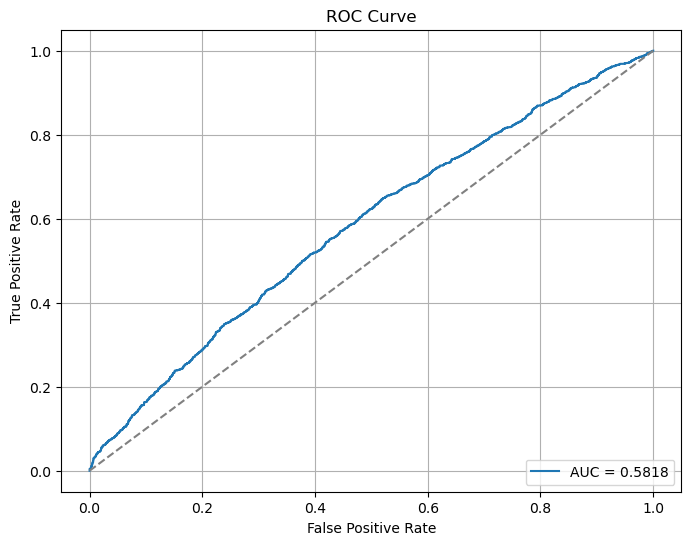

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, roc_curve
from sklearn.preprocessing import StandardScaler

# Scale for logistic regression because sensitive to scale

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# Initialize logistic regression model
logreg = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42) 
# Train the model
logreg.fit(X_train_scaled, Y_train)

for feature, weight in zip(X_train.columns, logreg.coef_[0]):
    print(f"{feature}: {weight:.4f}")

print(logreg.intercept_)


# exporting the model weights + features + scaler

with open('training/logistic_regression_model.pkl', 'wb') as f:
    pickle.dump(logreg, f)

with open('training/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
    
with open('training/feature_names.pkl', 'wb') as f:
    pickle.dump(feature_names, f)

# Predict on test set
y_pred = logreg.predict(X_test_scaled)
y_proba = logreg.predict_proba(X_test_scaled)[:, 1]  

# Calculate metrics
accuracy = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)
f1 = f1_score(Y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(Y_test, y_pred))

# Calculate AUC-ROC score
roc_auc = roc_auc_score(Y_test, y_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# XGBoost

In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, roc_curve
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import matplotlib.pyplot as plt


# set scale_pos_weight for class imbalance
neg, pos = np.bincount(Y_train)
scale_pos_weight = neg / pos

# 2. Define parameter grid
param_grid = {
    'max_depth': [2, 3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 300, 500],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.7, 0.9],
    'reg_alpha': [0, 0.5, 1.0],
    'reg_lambda': [1.0, 2.0]
}

# 3. Initialize XGBoost Classifier
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1
)

# 4. Cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 5. Grid Search
grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv,
    verbose=1,
    n_jobs=-1
)

# 6. Fit and get best model
grid_search.fit(X_train, Y_train)
best_model = grid_search.best_estimator_

In [ ]:

print(best_model)
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)
f1 = f1_score(Y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(Y_test, y_pred))

# Calculate AUC-ROC score
roc_auc = roc_auc_score(Y_test, y_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [ ]:
import shap
explainer = shap.Explainer(best_model)
shap_values = explainer(X_train)
shap.plots.beeswarm(shap_values)

# MLP

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold

mlp = MLPClassifier(max_iter=200)

# Define the hyperparameter grid you want to search over
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001],  # L2 penalty (regularization term)
    'learning_rate': ['constant', 'adaptive']
}

# Set up GridSearchCV
grid_search = GridSearchCV(mlp, param_grid, cv=3, n_jobs=-1, verbose=2)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# Fit to your training data
grid_search.fit(X_train_scaled, Y_train)

# Best params & best estimator
print("Best params:", grid_search.best_params_)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)
y_proba = best_model.predict_proba(X_test_scaled)[:, 1]  

accuracy = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)
f1 = f1_score(Y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(Y_test, y_pred))

# Calculate AUC-ROC score
roc_auc = roc_auc_score(Y_test, y_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()